In [63]:
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn import tree

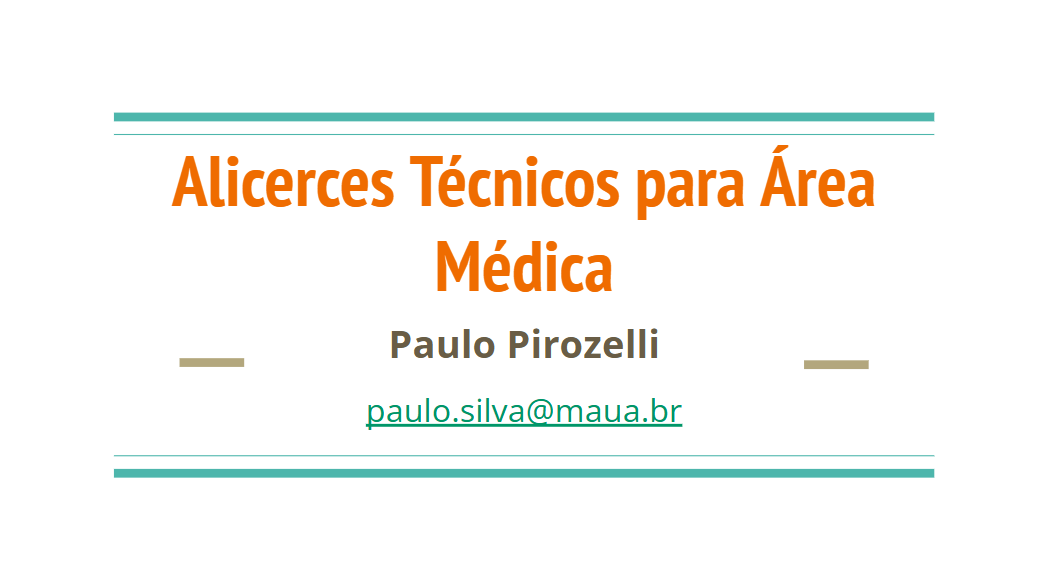

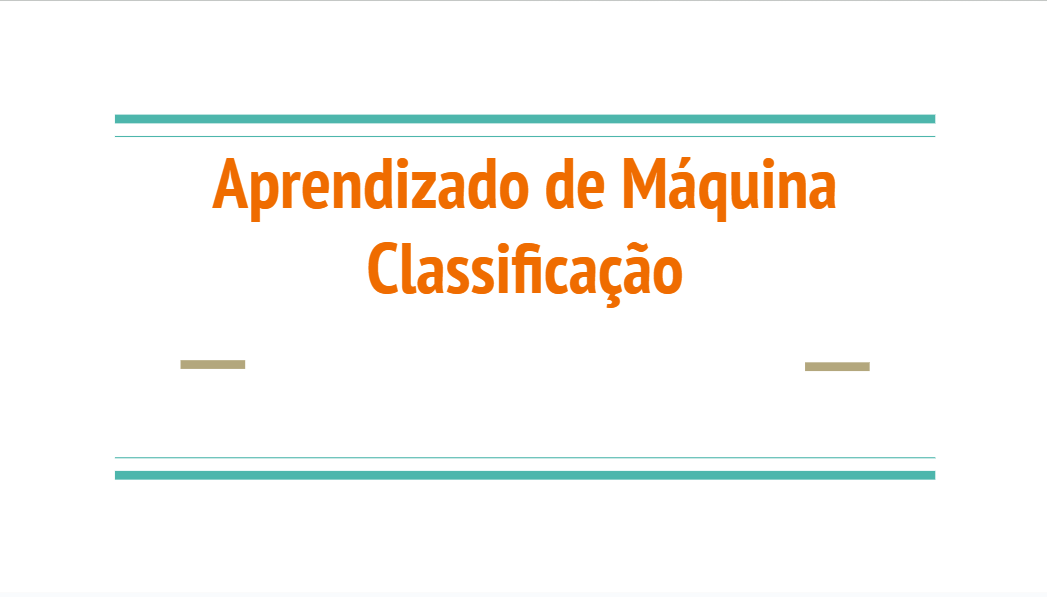

## Classificação

Nesta aula, apresentaremos mais dois modelos de classificação: **Árvore de Decisão** e **Floresta Aleatória**.

Vamos partir de um exemplo motivador para nossa explicação.

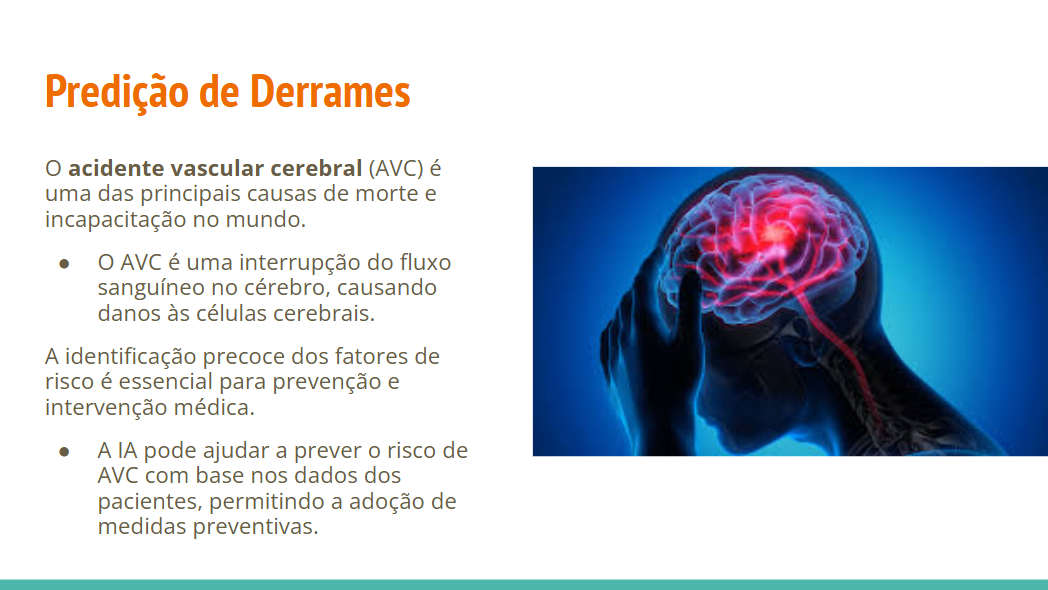

### Importação dos Dados

Para começar, vamos tentar abrir o conjunto de dados. Os dados estão relacionados a campanhas de marketing direto (ligações telefônicas) de uma instituição bancária portuguesa.

As informações estão em um arquivo no formato .csv (Comma-Separated Values). Nesse tipo de arquivo, as colunas são separadas por vírgulas ou algum outro separados e cada linha corresponde a um registro.

In [64]:
df = pd.read_csv('healthcare-dataset-stroke-data.csv')

print('Tamanho do dataset:', df.shape)

df.head()

Tamanho do dataset: (5110, 12)


,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


In [65]:
# Verificando as colunas presentes no dataset
df.columns

Index(['id', 'gender', 'age', 'hypertension', 'heart_disease', 'ever_married',
       'work_type', 'Residence_type', 'avg_glucose_level', 'bmi',
       'smoking_status', 'stroke'],
      dtype='object')

As variáveis presentes no dataset são as seguintes:

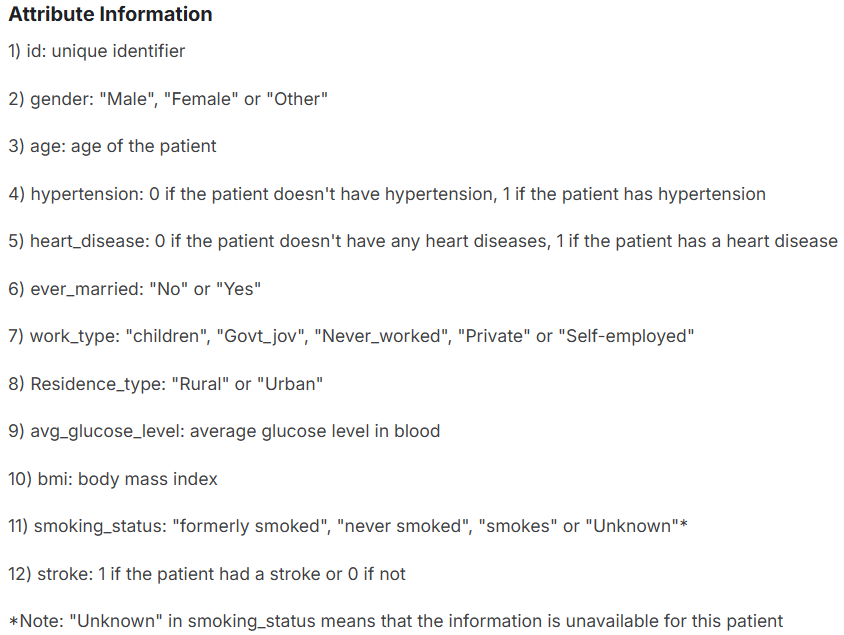

**Documentação completa:** https://www.kaggle.com/datasets/fedesoriano/stroke-prediction-dataset.

### Pré-processamento

#### 1. Integração de Bases de Dados

Nosso dataset já contém todas as informações. Não foi preciso integrar diferentes bases.

#### 2. Limpeza dos Dados

##### Dados Faltantes

Dados faltantes podem ser um problema sério para vários tipos de modelos, impedindo que possam rodar. Vamos checar se há valores faltantes e se houver, vamos removê-los.



In [66]:
# Verificar valores faltantes
print(df.isnull().sum())

id                     0
gender                 0
age                    0
hypertension           0
heart_disease          0
ever_married           0
work_type              0
Residence_type         0
avg_glucose_level      0
bmi                  201
smoking_status         0
stroke                 0
dtype: int64


Há 201 valores faltantes na coluna bmi. A solução que vou adotar é imputar a média da variável, que é um valor neutro.

In [67]:
# Calcula a média (ignorando os NaNs)
media_bmi = df['bmi'].mean()

# Imputa os valores faltantes com a média
df['bmi'].fillna(media_bmi, inplace=True)

# Verifica se ainda restaram valores faltantes
print(f'Valores faltantes após imputação: {df["bmi"].isna().sum()}')

Valores faltantes após imputação: 0


<ipython-input-67-c111d7719539>:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['bmi'].fillna(media_bmi, inplace=True)


#### 3. Tipos de variáveis

Nossos dados contém variáveis de diferentes de tipos. Precisamos converter as variáveis categóricas em variáveis quantitativas.

In [68]:
# Número de valores únicos em cada colunas
print('coluna | tipo | valores únicos')

for column in df.columns:
    unique_values = df[column].nunique()
    print(f"{column}, {df[column].dtype}, {unique_values}")

coluna | tipo | valores únicos
id, int64, 5110
gender, object, 3
age, float64, 104
hypertension, int64, 2
heart_disease, int64, 2
ever_married, object, 2
work_type, object, 5
Residence_type, object, 2
avg_glucose_level, float64, 3979
bmi, float64, 419
smoking_status, object, 4
stroke, int64, 2


Podemos ver que algumas dessas variáveis são quantitativas, outras são qualitativas. Mas algumas não são óbvias.

Podemos explorar alguns em mais detalhes, para entender o que são esses valores.

In [69]:
# Detecta variáveis qualitativas (tipos object ou category)
qualitativas = df.select_dtypes(include=['object', 'category']).columns

# Imprime os valores únicos de cada uma
for coluna in qualitativas:
    print(f'\nColuna: {coluna}')
    print(df[coluna].unique())


Coluna: gender
['Male' 'Female' 'Other']

Coluna: ever_married
['Yes' 'No']

Coluna: work_type
['Private' 'Self-employed' 'Govt_job' 'children' 'Never_worked']

Coluna: Residence_type
['Urban' 'Rural']

Coluna: smoking_status
['formerly smoked' 'never smoked' 'smokes' 'Unknown']


A variável `ever_married` contém apenas dois valores (binária), que podemos substituir simplesmente por 0-1. As demais variáveis apresentam múltiplos rótulos. Para esses casos, vamos utilizar uma codificação one-hot ou dummy.

In [70]:
# Codifica variáveis categóricas com one-hot encoding
df = pd.get_dummies(df, drop_first=True)

df

,id,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke,gender_Male,gender_Other,ever_married_Yes,work_type_Never_worked,work_type_Private,work_type_Self-employed,work_type_children,Residence_type_Urban,smoking_status_formerly smoked,smoking_status_never smoked,smoking_status_smokes
0,9046,67.0,0,1,228.69,36.600000,1,True,False,True,False,True,False,False,True,True,False,False
1,51676,61.0,0,0,202.21,28.893237,1,False,False,True,False,False,True,False,False,False,True,False
2,31112,80.0,0,1,105.92,32.500000,1,True,False,True,False,True,False,False,False,False,True,False
3,60182,49.0,0,0,171.23,34.400000,1,False,False,True,False,True,False,False,True,False,False,True
4,1665,79.0,1,0,174.12,24.000000,1,False,False,True,False,False,True,False,False,False,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5105,18234,80.0,1,0,83.75,28.893237,0,False,False,True,False,True,False,False,True,False,True,False
5106,44873,81.0,0,0,125.20,40.000000,0,False,False,True,False,False,True,False,True,False,True,False
5107,19723,35.0,0,0,82.99,30.600000,0,False,False,True,False,False,True,False,False,False,True,False
5108,37544,51.0,0,0,166.29,25.600000,0,True,False,True,False,True,False,False,False,True,False,False


**Pergunta:** Por que eu usei a mesma solução para a variável binária?

In [71]:
print(df.shape)

(5110, 18)


**Importante:** Essa transformação fez com que nosso dataset passasse de 12 para 18 colunas. Essa alteração pode dificultar a convergência e a precisão de alguns modelos, que terão que estimar muito mais parâmetros simultaneamente.

#### 4. Outliers

Vou deixar para resolver o problema dos valores extremos com o escalonamento.

#### 5. Escalonamento

Vamos também escalonar os nossos dados, utilizando uma estratégia z-score. As variáveis terão aproximadamente média 0 e desvio-padrão 1.

**Importante:** Antes, precisamos separar nossos dados de entrada e saída (não queremos normalizar os dados de saída). Depois vamos juntar com os dados de entrada normalizados.

In [72]:
y = df['stroke']

# Elimina a coluna de saída
X = df.drop(columns=['stroke'])

print(X.shape)

(5110, 17)


In [73]:
scaler = StandardScaler()

scaler.fit(X)

X = scaler.transform(X)

# Print dataset normalizado
print('Tamanho do dataset:', X.shape)
print(X)

Tamanho do dataset: (5110, 17)
[[-1.29831203  1.05143428 -0.32860186 ...  2.1849511  -0.7667743
  -0.42731326]
 [ 0.71637149  0.78607007 -0.32860186 ... -0.45767615  1.30416474
  -0.42731326]
 [-0.25547819  1.62639008 -0.32860186 ... -0.45767615  1.30416474
  -0.42731326]
 ...
 [-0.79371959 -0.36384151 -0.32860186 ... -0.45767615  1.30416474
  -0.42731326]
 [ 0.04849658  0.34379639 -0.32860186 ...  2.1849511  -0.7667743
  -0.42731326]
 [ 0.38569496  0.03420481 -0.32860186 ... -0.45767615 -0.7667743
  -0.42731326]]


#### 6. Balanceamento de Dados

Em tarefas de classificação, é preciso garantir que as classes sejam igualmente representadas (ou algo próximo disso). De outra forma, o modelo pode se preocupar demais com a classe majoritária e deixar de lado a classe minoritária.


**Dados desbalanceados:**

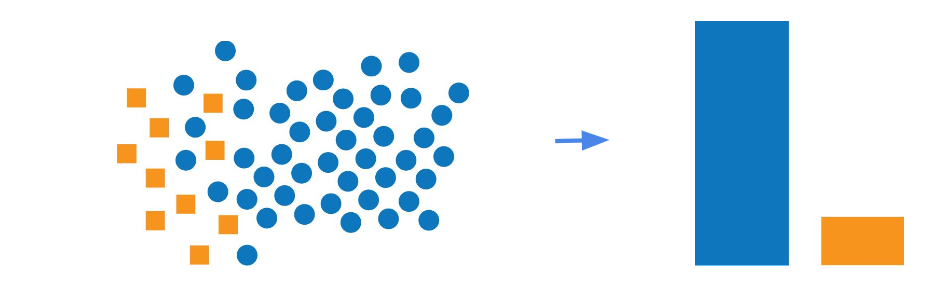

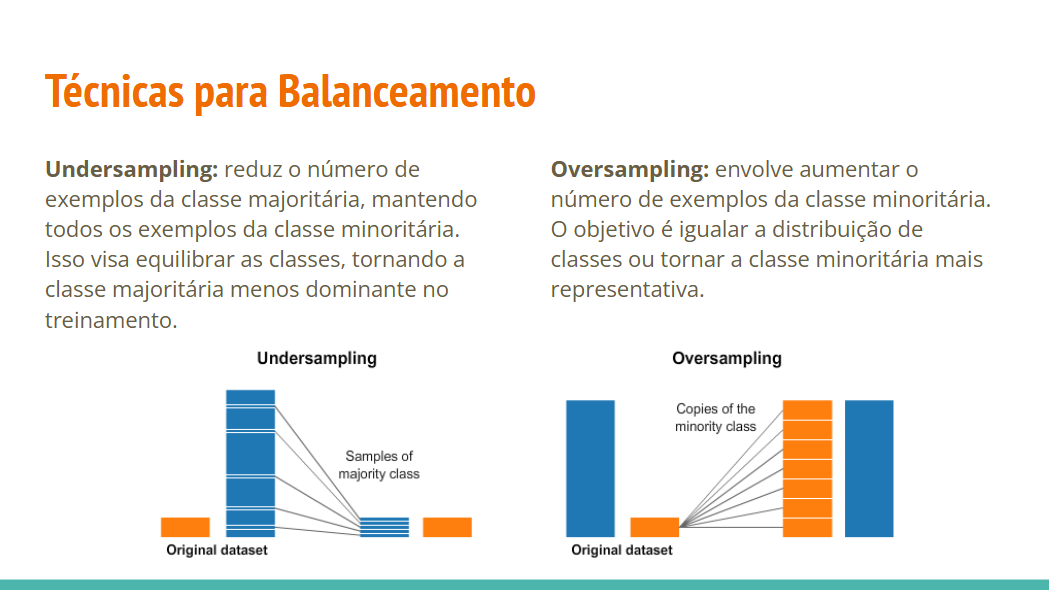

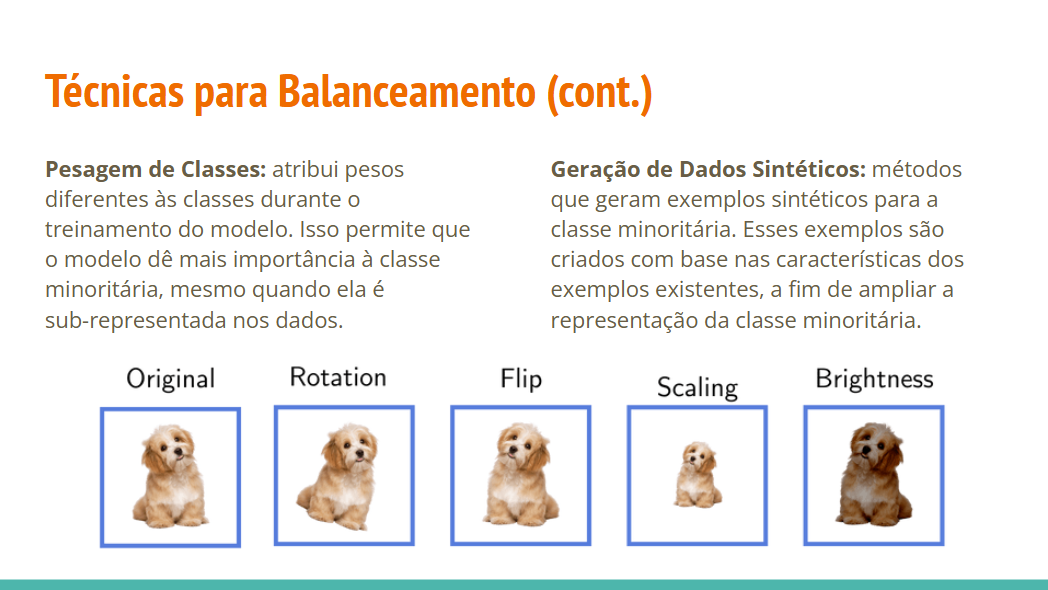

Vamos verificar se o nosso conjunto de dados é desbalanceado em relação à variável de interesse.

In [74]:
# Verificar balanceamento do dataset
print('Valor Absoluto')
print(df['stroke'].value_counts())
print('\n')

print('Valor Percentual')
print(df['stroke'].value_counts() / len(df) * 100)

Valor Absoluto
stroke
0    4861
1     249
Name: count, dtype: int64


Valor Percentual
stroke
0    95.127202
1     4.872798
Name: count, dtype: float64


Nessa aula, não vamos usar nenhuma técnica para garantir o balanceamento dos dados. Vamos apenas exigir que as classes estejam **estratificadas**; isto é, que a proporção das classes seja a mesma no conjunto treinamento e teste.

In [75]:
# Partição estratificada
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

print('Dataset de treinamento:', X_train.shape)
print('Dataset de teste:', X_test.shape)

Dataset de treinamento: (4088, 17)
Dataset de teste: (1022, 17)


## Modelos

Nesta aula, veremos alguns modelos clássicos de classificação, como regressão logística, k-vizinhos próximos, árvore de decisão e support vector machine.

### Regressão Logística e Árvore de Decisão

Para compararmos os novos modelos com os modelos anteriores, vamos treinar uma regressão logística e uma árvore de decisão no nosso conjunto de dados.

No sklearn, esse processo consiste em **quatro** passos principais:

1.   Instanciar o modelo.
2.   Ajustar para os dados de treinamento.
3.   Fazer a predição para os dados de teste.
4.   Calcular as métricas adequadas.



Vamos criar um dicionário para armazenar os resultados dos classificadores.

In [76]:
class_metrics = {}

In [77]:
# Treinando o classificador Regressão Logística
clf_dt = LogisticRegression()
clf_dt.fit(X_train, y_train)

# Aplicando ao conjunto de teste
dt_pred = clf_dt.predict(X_test)

# Calculando métricas
dt_acc = accuracy_score(y_test, dt_pred)
dt_f1 = f1_score(y_test, dt_pred)

# Armazenando resultados
class_metrics['RegLog'] = [dt_acc, dt_f1]

print(f'Regressão Logística. Acurácia: {dt_acc * 100:.4}, F1-score: {dt_f1 * 100:.4}')

Regressão Logística. Acurácia: 95.11, F1-score: 3.846


In [78]:
# Treinando o classificador k-NN
clf_lr = KNeighborsClassifier(n_neighbors=3)
clf_lr.fit(X_train, y_train)

# Aplicando ao conjunto de teste
lr_pred = clf_lr.predict(X_test)

# Calculando métricas
lr_acc = accuracy_score(y_test, lr_pred)
lr_f1 = f1_score(y_test, lr_pred)

# Armazenando resultados
class_metrics['kNN'] = [lr_acc, lr_f1]

print(f'k-Vizinhos Próximos. Acurácia: {lr_acc * 100:.4}, F1-score: {lr_f1 * 100:.4}')

k-Vizinhos Próximos. Acurácia: 94.62, F1-score: 9.836


Para comparar os resultados, podemos plotar um gráfico. Para isso, definimos uma função que, quando chamada, exibe os resultados armazenados no dicionário.

In [79]:
def plot_model_metrics(metrics_dict):
    models = list(metrics_dict.keys())
    accuracy = [val[0] for val in metrics_dict.values()]
    fscore = [val[1] for val in metrics_dict.values()]

    x = np.arange(len(models))
    width = 0.35

    plt.bar(x - width/2, accuracy, width, label='Accuracy')
    plt.bar(x + width/2, fscore, width, label='F-score')
    plt.xticks(x, models)
    plt.ylabel('Score')
    plt.title('Model Comparison')
    plt.legend()
    plt.show()

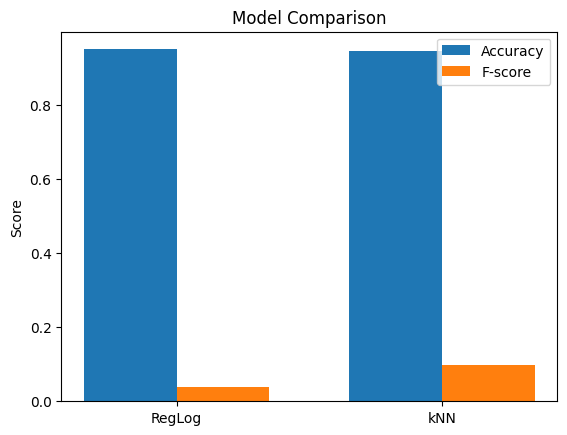

In [80]:
# Plotando os resultados
plot_model_metrics(class_metrics)

### Árvore de Decisão

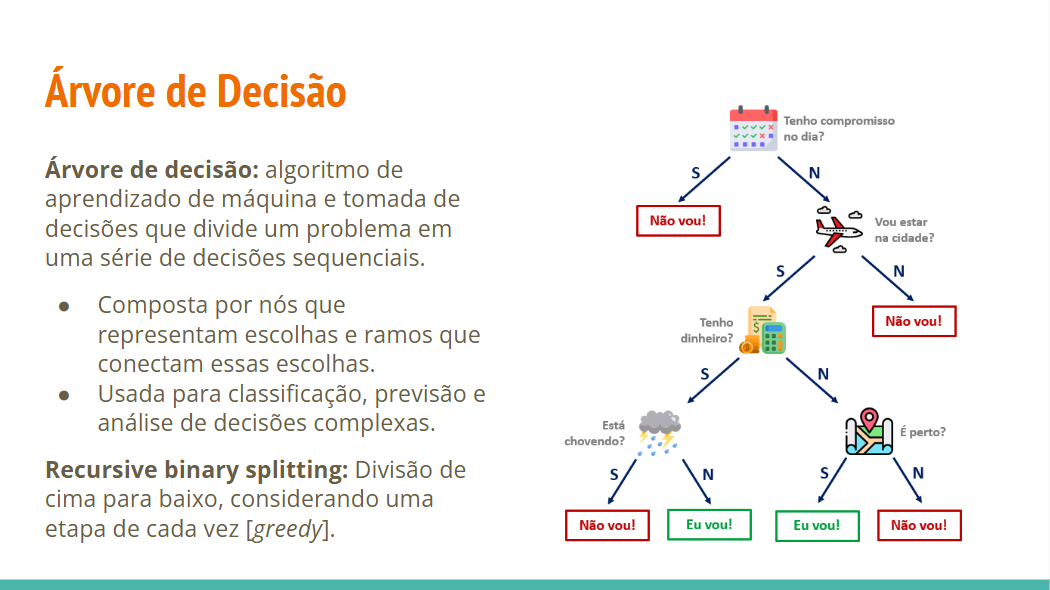

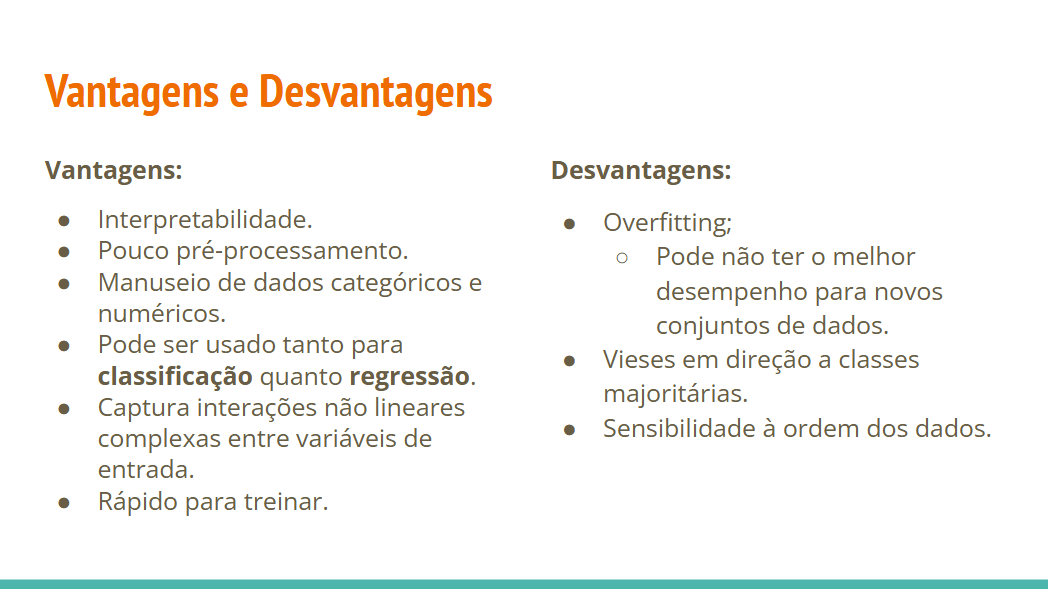

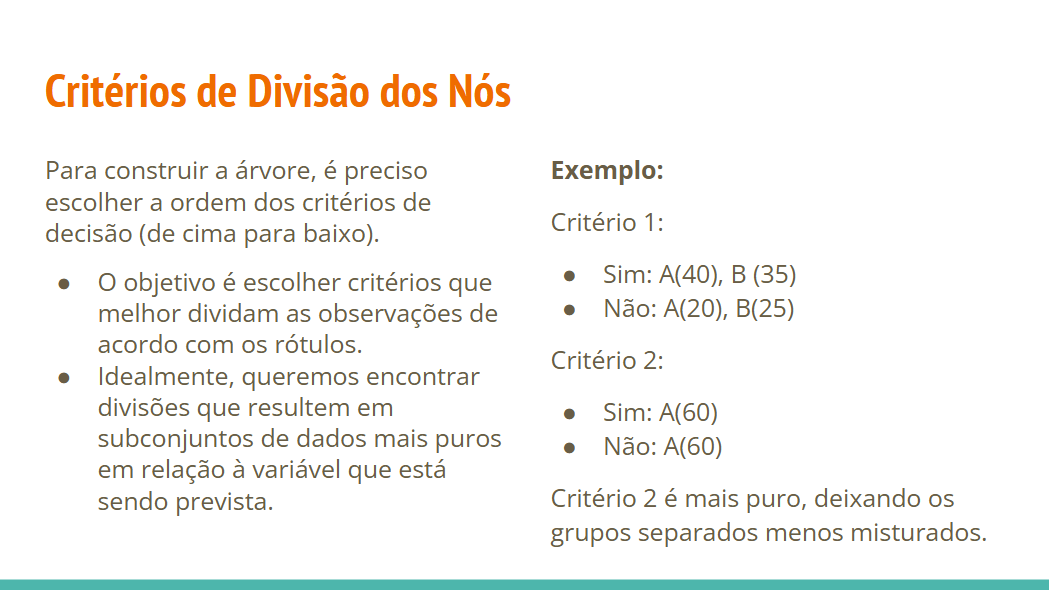

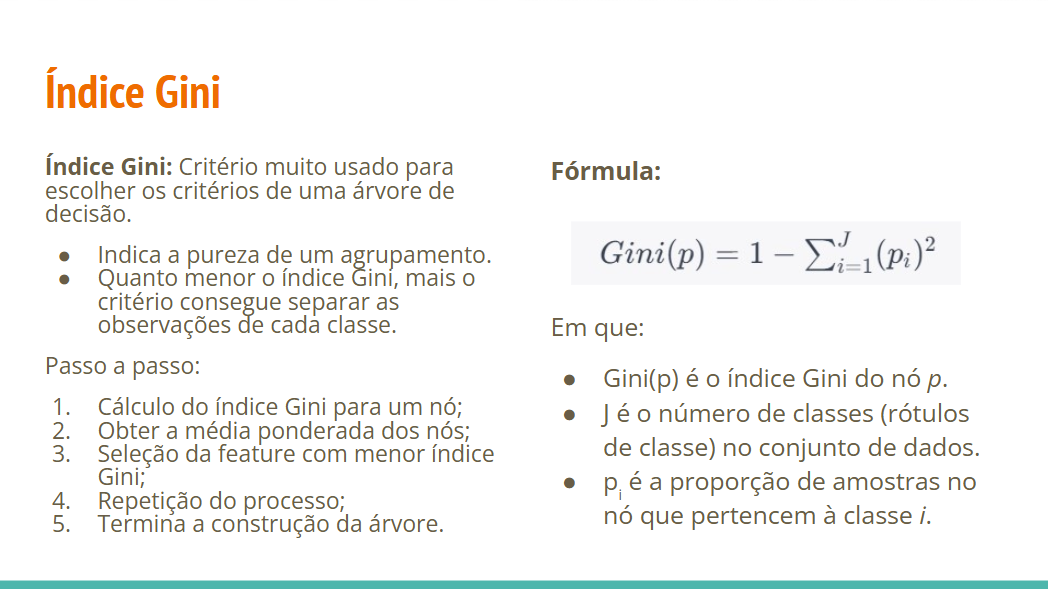

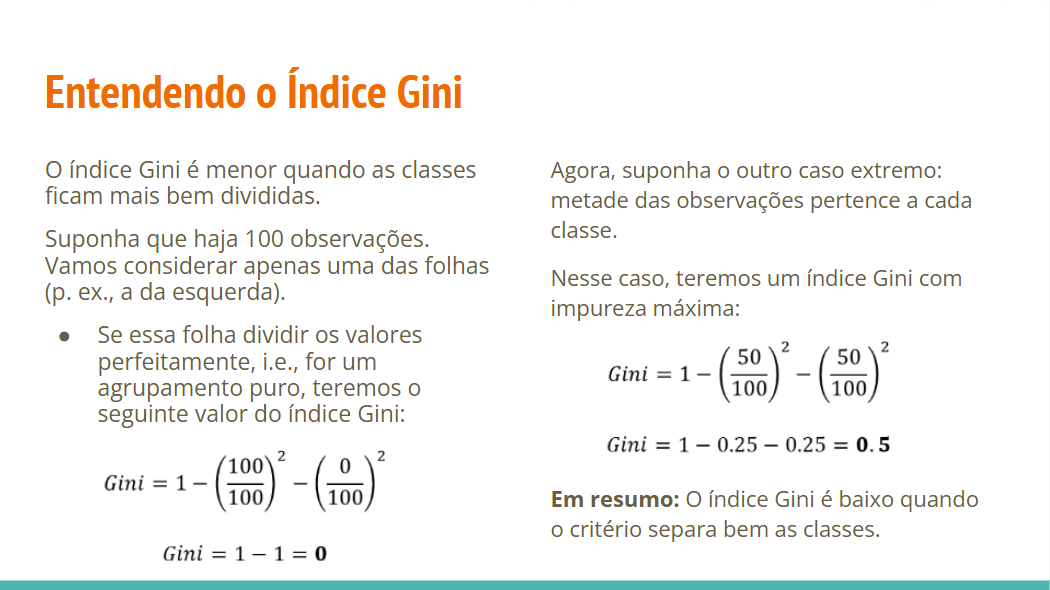

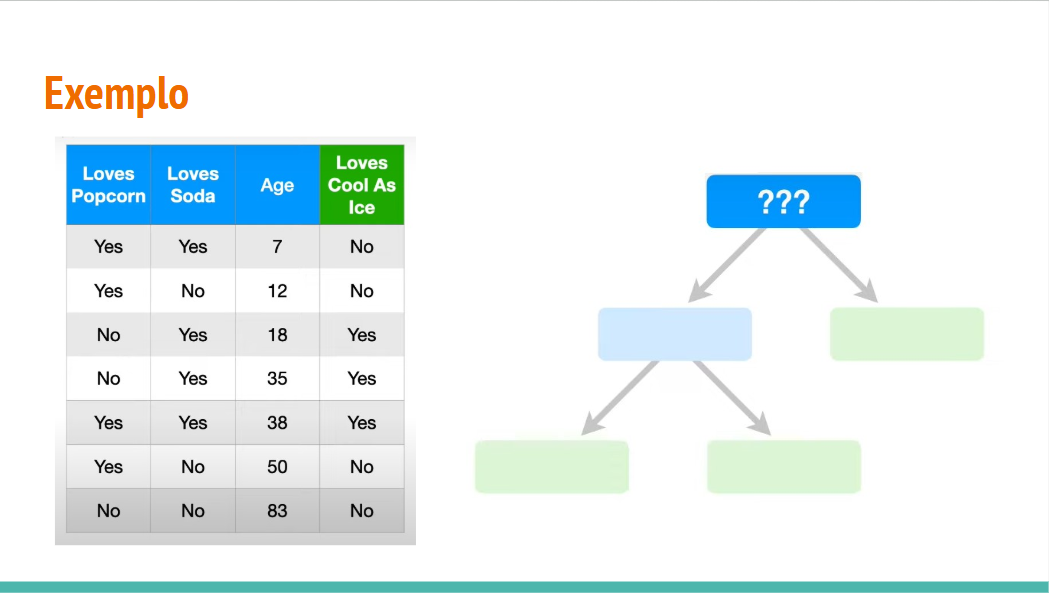

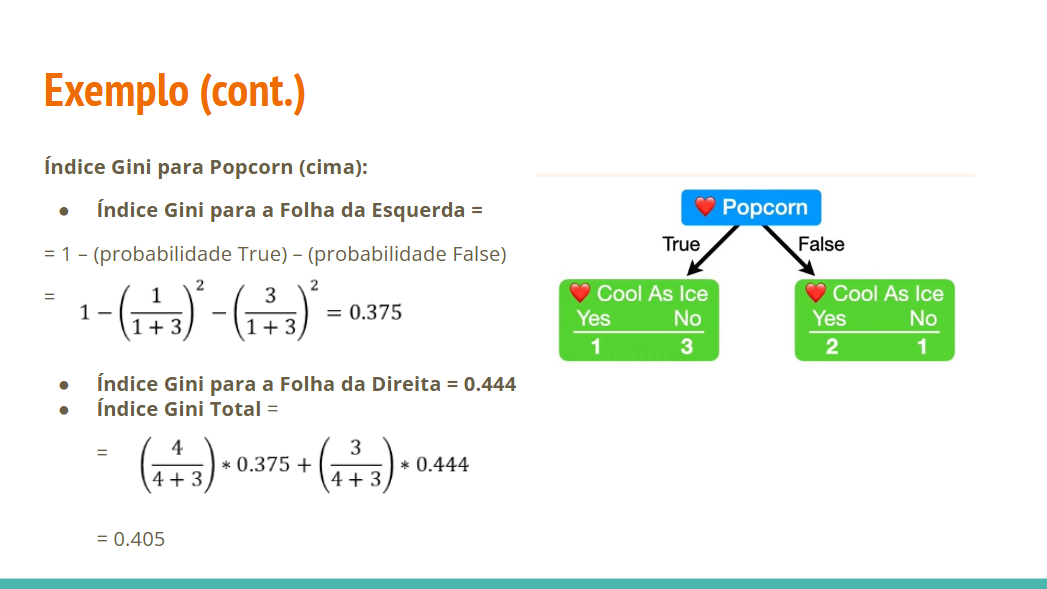

Vamos treinar nossa árvore de decisão.

In [81]:
# Cria o modelo
clf_tree = DecisionTreeClassifier()

# Ajusta os parâmetros
clf_tree.fit(X_train, y_train)

DecisionTreeClassifier()

In [82]:
# Aplica ao conjunto teste
tree_pred = clf_tree.predict(X_test)

# Calcula métricas
tree_acc = accuracy_score(y_test, tree_pred)
tree_f1 = f1_score(y_test, tree_pred)

# Calcula métricas de avaliação
class_metrics['DecTree'] = [tree_acc, tree_f1]

print(f'Árvore de Decisão. Acurácia: {tree_acc * 100:.4}, F1-score: {tree_f1 * 100:.4}')

Árvore de Decisão. Acurácia: 91.98, F1-score: 19.61


Podemos plotar novamente os resultados comparando os modelos.

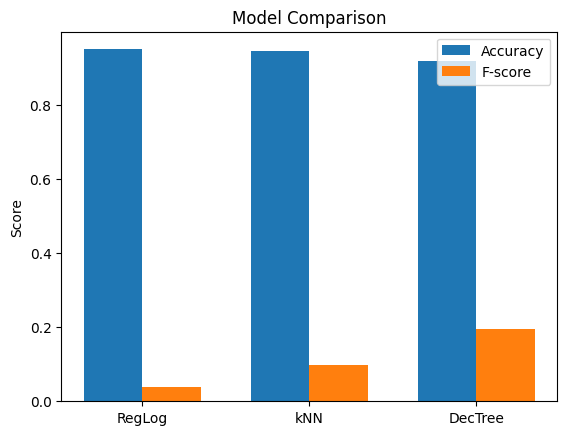

In [83]:
plot_model_metrics(class_metrics)

Uma das vantagens da árvore de decisão é que ela estabelece uma sequência de decisões para a classificação dos dados. Existem ferramentas que permitem visualizar essa estrutura.

In [84]:
# Selecionar as colunas de entrada

cols_in = list(df.columns)
cols_out = df['stroke']

cols_in.remove('stroke')

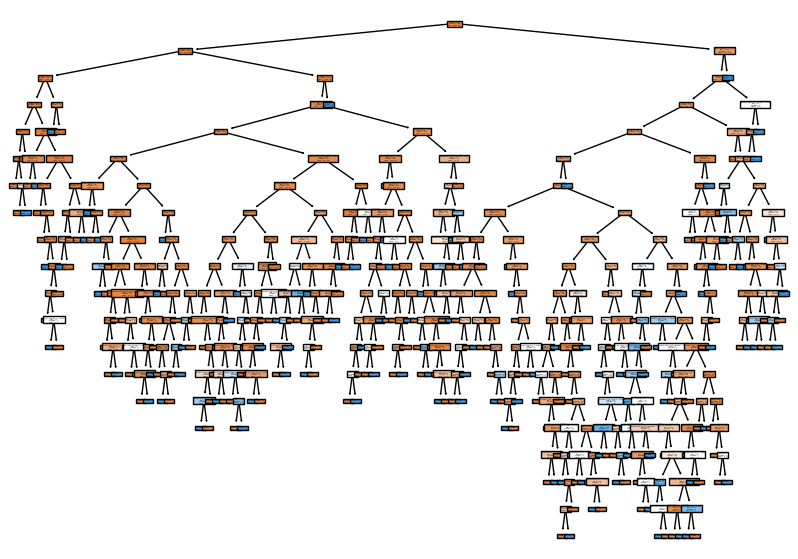

In [85]:
columns = df.columns

fig = plt.figure(figsize=(10,7))
_ = tree.plot_tree(clf_tree,
                   feature_names=cols_in,
                   filled=True)

### Floresta Aleatória

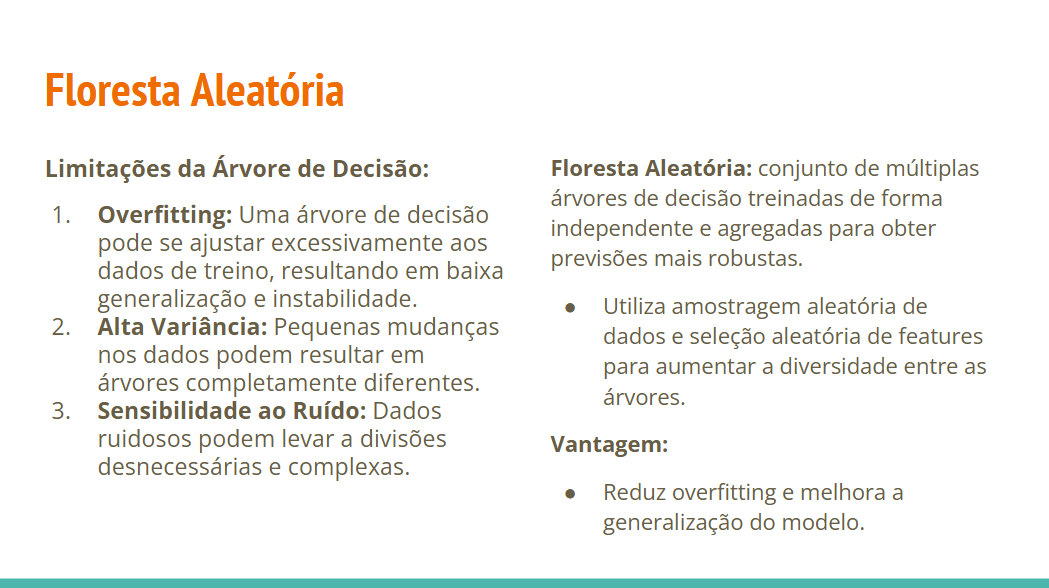

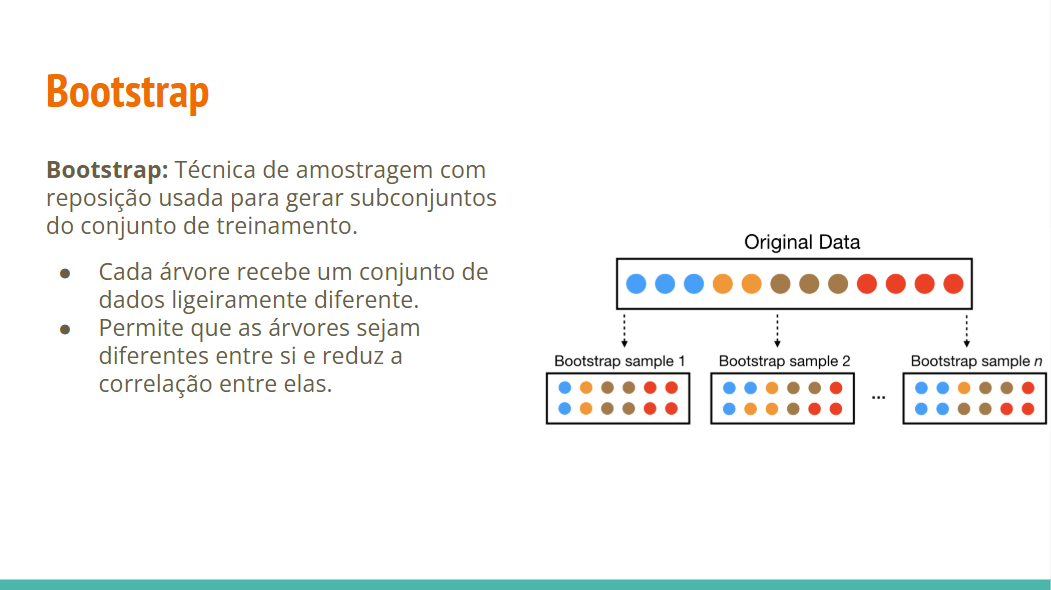

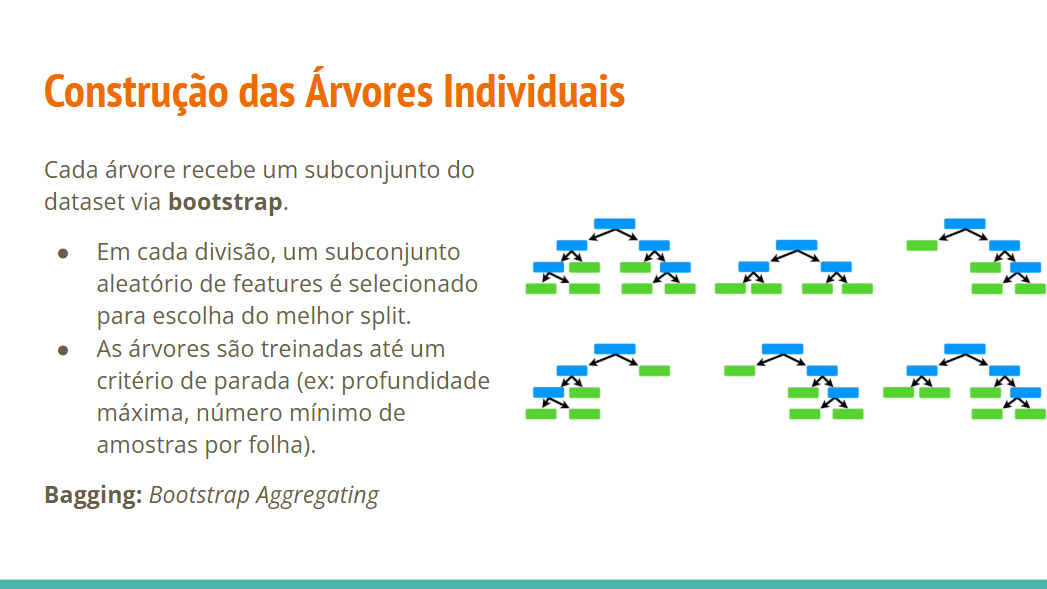

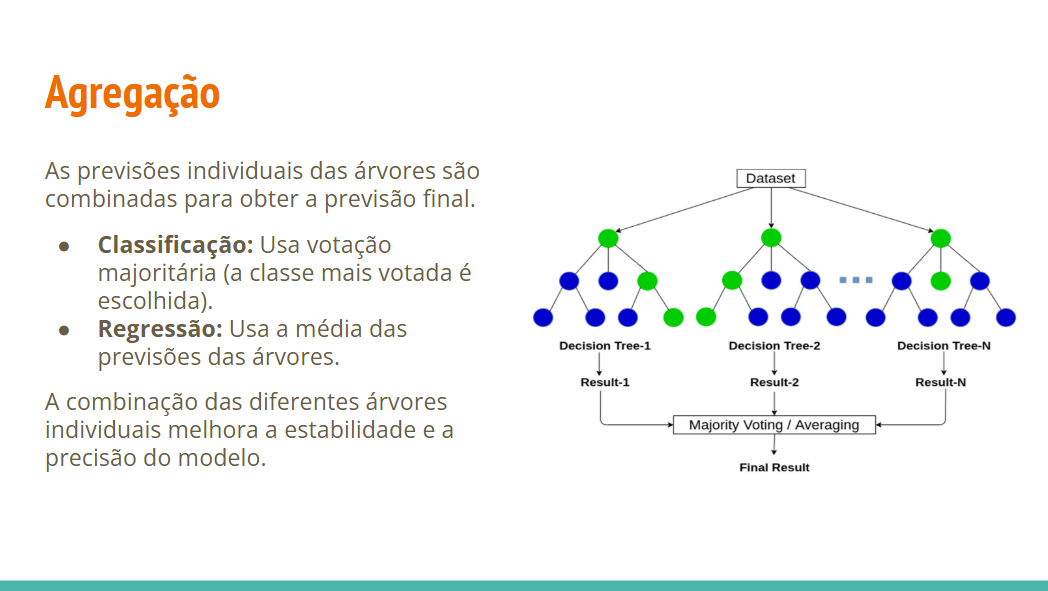

Vamos agora treinar uma floresta aleatória para o nosso conjunto de dados.

In [86]:
# Treinando o classificador Floresta Aleatória
clf_rf = RandomForestClassifier()
clf_rf.fit(X_train, y_train)

# Aplicando ao conjunto de teste
rf_pred = clf_rf.predict(X_test)

# Calculando métricas
rf_acc = accuracy_score(y_test, rf_pred)
rf_f1 = f1_score(y_test, rf_pred)

# Armazenando resultados
class_metrics['RandFor'] = [rf_acc, rf_f1]

print(f'Floresta Aleatória. Acurácia: {rf_acc * 100:.4}, F1-score: {rf_f1 * 100:.4}')

Floresta Aleatória. Acurácia: 94.91, F1-score: 3.704


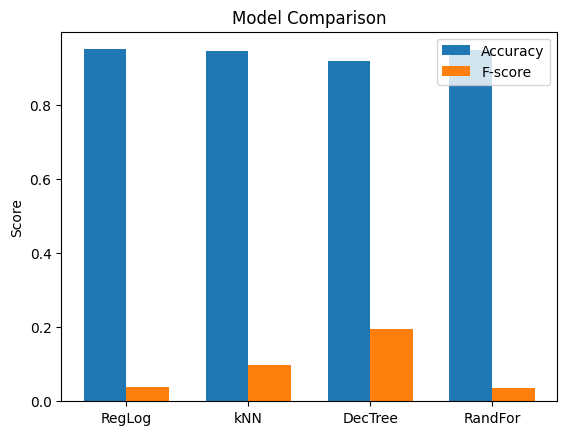

In [87]:
# Plotando os resultados
plot_model_metrics(class_metrics)

# **Atividade: Previsão de Doença Cardíaca com Aprendizado de Máquina**

## **Contexto**
As doenças cardiovasculares são a principal causa de morte no mundo, representando **31% de todas as mortes globais**. O reconhecimento precoce dos fatores de risco pode ajudar na prevenção e no tratamento adequado.

Neste estudo, você utilizará **dados clínicos de pacientes** para desenvolver um modelo de aprendizado de máquina capaz de prever se um paciente tem **doença cardíaca** com base em suas características médicas.

---

## **Objetivo da Tarefa**
Criar um **modelo de classificação** que receba as características clínicas do paciente e **preveja a presença de doença cardíaca** (`HeartDisease`: **1** = Doença cardíaca, **0** = Normal).

---

## **Descrição dos Dados**
Cada paciente é descrito por **11 atributos**, incluindo idade, tipo de dor no peito, colesterol, pressão arterial, frequência cardíaca máxima, entre outros.

### **📌 Entrada (features)**
- `Age`: Idade do paciente (anos).  
- `Sex`: Sexo biológico (`M`: Masculino, `F`: Feminino).  
- `ChestPainType`: Tipo de dor no peito (`TA`, `ATA`, `NAP`, `ASY`).  
- `RestingBP`: Pressão arterial em repouso (mm Hg).  
- `Cholesterol`: Nível de colesterol sérico (mg/dl).  
- `FastingBS`: Glicose em jejum (>120 mg/dl = **1**, caso contrário = **0**).  
- `RestingECG`: Resultados do eletrocardiograma (`Normal`, `ST`, `LVH`).  
- `MaxHR`: Frequência cardíaca máxima atingida.  
- `ExerciseAngina`: Angina induzida por exercício (`Y` = Sim, `N` = Não).  
- `Oldpeak`: Depressão do segmento ST durante o exercício.  
- `ST_Slope`: Inclinação do segmento ST (`Up`, `Flat`, `Down`).  

### **🎯 Saída (target)**
- `HeartDisease`: **1** se o paciente tem doença cardíaca, **0** caso contrário.  

Link para baixar o dataset: https://www.kaggle.com/datasets/fedesoriano/heart-failure-prediction

---

## **Tarefa**
1. **Pré-processamento dos dados**  
   - Converter atributos categóricos em valores numéricos (ex.: `ChestPainType`, `RestingECG`).  
   - Normalizar ou padronizar variáveis numéricas se necessário.  

2. **Dividir o dataset** em treino e teste para avaliação do modelo.  

3. **Treinar modelos de classificação** para a tarefa.  

4. **Avaliar o desempenho** do modelo usando **acurácia** e **F1-score**.  

---

## **Pergunta Final**
➡ **Qual modelo consegue prever com maior precisão a presença de doença cardíaca?**  


In [88]:
df = pd.read_csv('heart.csv')

print(f'Dimensionalidade: {df.shape}')

df.head()

Dimensionalidade: (918, 12)


,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0
1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1
2,37,M,ATA,130,283,0,ST,98,N,0.0,Up,0
3,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,1
4,54,M,NAP,150,195,0,Normal,122,N,0.0,Up,0


Vejamos se as classes estão balanceadas.

HeartDisease
1    0.553377
0    0.446623
Name: proportion, dtype: float64


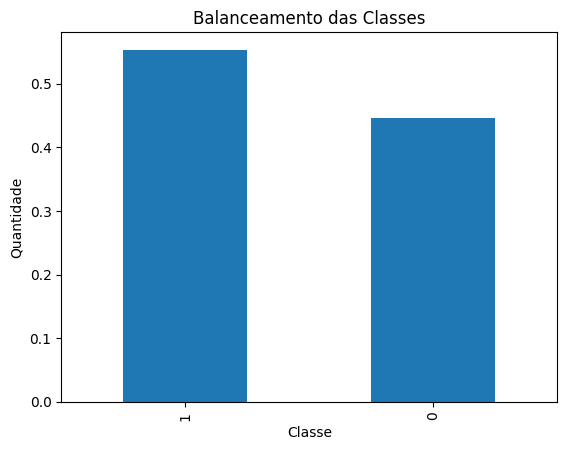

In [89]:
print(df['HeartDisease'].value_counts(normalize=True))

df['HeartDisease'].value_counts(normalize=True).plot(kind='bar')
plt.title('Balanceamento das Classes')
plt.xlabel('Classe')
plt.ylabel('Quantidade')
plt.show()

### Pré-Processamento

Conversão de variáveis categóricas.

In [90]:
df = pd.get_dummies(df, drop_first=True)

df.head()

,Age,RestingBP,Cholesterol,FastingBS,MaxHR,Oldpeak,HeartDisease,Sex_M,ChestPainType_ATA,ChestPainType_NAP,ChestPainType_TA,RestingECG_Normal,RestingECG_ST,ExerciseAngina_Y,ST_Slope_Flat,ST_Slope_Up
0,40,140,289,0,172,0.0,0,True,True,False,False,True,False,False,False,True
1,49,160,180,0,156,1.0,1,False,False,True,False,True,False,False,True,False
2,37,130,283,0,98,0.0,0,True,True,False,False,False,True,False,False,True
3,48,138,214,0,108,1.5,1,False,False,False,False,True,False,True,True,False
4,54,150,195,0,122,0.0,0,True,False,True,False,True,False,False,False,True


Normalização

In [91]:
y = df['HeartDisease']

# Elimina a coluna de saída
X = df.drop(columns=['HeartDisease'])

# Normalização
scaler = StandardScaler()

scaler.fit(X)

X = scaler.transform(X)

print(X)

[[-1.4331398   0.41090889  0.82507026 ... -0.8235563  -1.00218103
   1.15067399]
 [-0.47848359  1.49175234 -0.17196105 ... -0.8235563   0.99782372
  -0.86905588]
 [-1.75135854 -0.12951283  0.7701878  ... -0.8235563  -1.00218103
   1.15067399]
 ...
 [ 0.37009972 -0.12951283 -0.62016778 ...  1.21424608  0.99782372
  -0.86905588]
 [ 0.37009972 -0.12951283  0.34027522 ... -0.8235563   0.99782372
  -0.86905588]
 [-1.64528563  0.30282455 -0.21769643 ... -0.8235563  -1.00218103
   1.15067399]]


Dividir entre treino e teste.

In [92]:
# Dividir em treino e teste
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

### Treinamento de Modelos

In [93]:
# Dicionário com modelos
modelos = {
    'Árvore de Decisão': DecisionTreeClassifier(),
    'Floresta Aleatória': RandomForestClassifier(),
    'Regressão Logística': LogisticRegression(),
    'KNN': KNeighborsClassifier(n_neighbors=2)
}

# Armazenar métricas
resultados = {'Modelo': [], 'Acurácia': [], 'F1-score': []}

# Treinar e avaliar
for nome, modelo in modelos.items():
    modelo.fit(X_train, y_train)
    y_pred = modelo.predict(X_test)

    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    resultados['Modelo'].append(nome)
    resultados['Acurácia'].append(acc)
    resultados['F1-score'].append(f1)

In [94]:
# Print dos resultados
print("Resultados dos Modelos:\n")
for i in range(len(resultados['Modelo'])):
    nome = resultados['Modelo'][i]
    acc = resultados['Acurácia'][i]
    f1 = resultados['F1-score'][i]
    print(f"{nome:<20} | Acurácia: {acc:.4f} | F1-score: {f1:.4f}")

Resultados dos Modelos:

Árvore de Decisão    | Acurácia: 0.7935 | F1-score: 0.8190
Floresta Aleatória   | Acurácia: 0.8913 | F1-score: 0.9038
Regressão Logística  | Acurácia: 0.8859 | F1-score: 0.9005
KNN                  | Acurácia: 0.8478 | F1-score: 0.8526


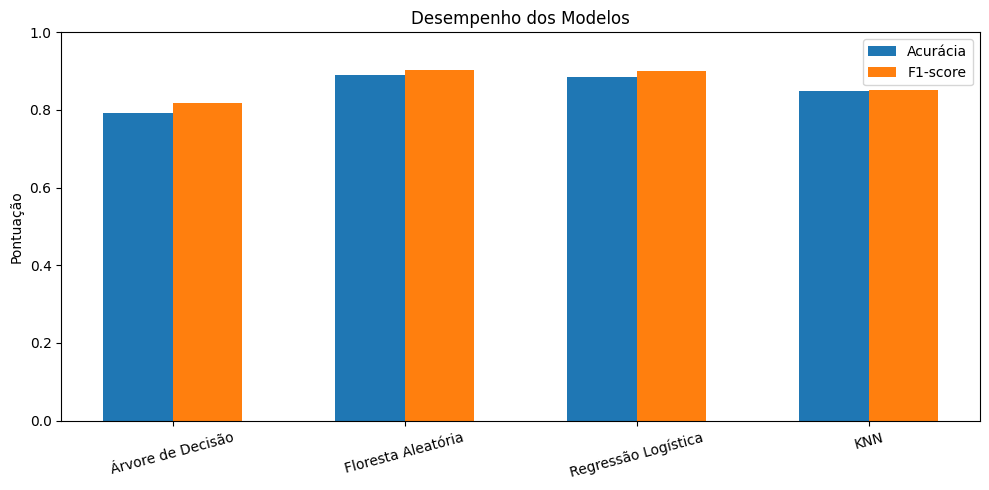

In [95]:
# Criar DataFrame com os resultados (caso ainda não tenha)
resultados_df = pd.DataFrame(resultados)

# Dados
modelos = resultados_df['Modelo']
acuracias = resultados_df['Acurácia']
f1_scores = resultados_df['F1-score']
x = np.arange(len(modelos))

# Plot
plt.figure(figsize=(10, 5))
plt.bar(x - 0.15, acuracias, width=0.3, label='Acurácia')
plt.bar(x + 0.15, f1_scores, width=0.3, label='F1-score')

# Configurações
plt.xticks(x, modelos, rotation=15)
plt.ylim(0, 1)
plt.ylabel('Pontuação')
plt.title('Desempenho dos Modelos')
plt.legend()
plt.tight_layout()
plt.show()

Conclusão: O melhor modelo, em termos de F1-score, foi a **Regressão Logística** (0.9005). Os resultados, porém, foram bem próximos aos modelos K-NN e Floresta Aleatória. O modelo com o pior desempenho foi a Árvore de Decisão.